In [ ]:
pip install numpy pandas matplotlib seaborn scikit-learn tensorflow keras shap streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 129.2 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Mon Oct  6 08:36:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   74C    P0             32W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# installs (Colab usually has these; safe to run)
!pip install -q tensorflow  # if you want a specific TF version (optional)
!pip install -q tf-explain           # optional (we'll use later for Grad-CAM)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# set path to your dataset (exact path you gave)
import pathlib, os
DATA_DIR = pathlib.Path('/content/drive/MyDrive/X ray Dataset/chest_xray')

# quick check
print("Exists:", DATA_DIR.exists())
print("Contents:", list(DATA_DIR.iterdir()))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Exists: True
Contents: [PosixPath('/content/drive/MyDrive/X ray Dataset/chest_xray/val'), PosixPath('/content/drive/MyDrive/X ray Dataset/chest_xray/__MACOSX'), PosixPath('/content/drive/MyDrive/X ray Dataset/chest_xray/chest_xray'), PosixPath('/content/drive/MyDrive/X ray Dataset/chest_xray/train'), PosixPath('/content/drive/MyDrive/X ray Dataset/chest_xray/test')]


In [ ]:
import tensorflow as tf

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dir = str(DATA_DIR / 'train')
val_dir   = str(DATA_DIR / 'val')
test_dir  = str(DATA_DIR / 'test')

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 5263 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


In [ ]:
rescale = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.08),   # ±8%
    tf.keras.layers.RandomZoom(0.08),
    # optionally: tf.keras.layers.RandomContrast(0.08),
])

# example of applying augmentation during training: map the augmentation onto train_ds
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)


In [ ]:
train_ds = augmented_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


/tmp/ipython-input-2699799553.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  title = class_names[int(labels[i])]


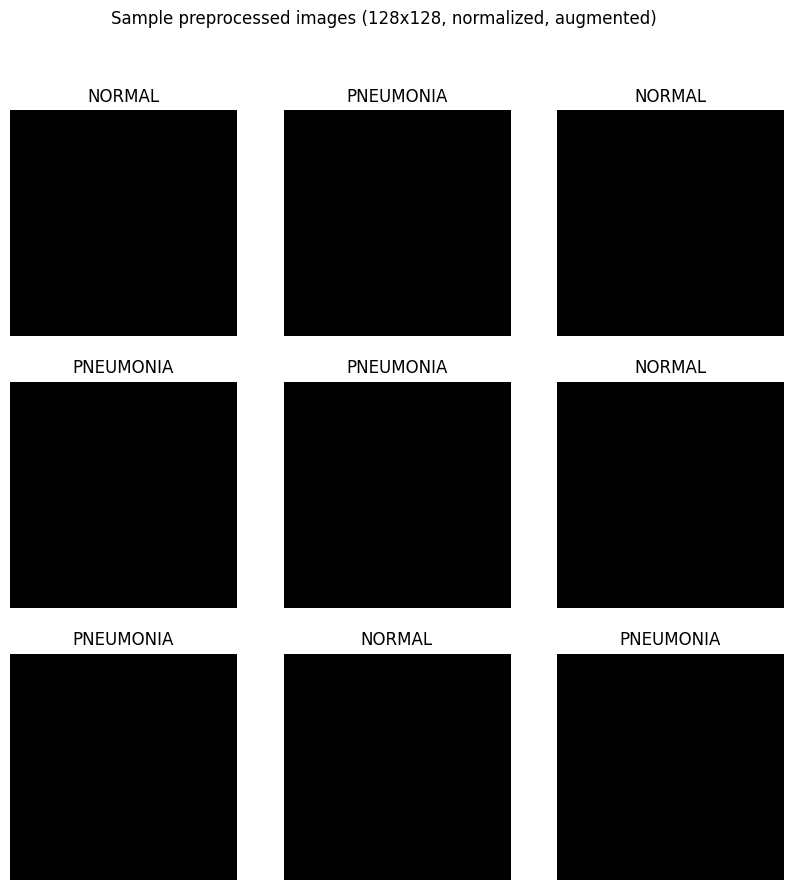

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))

# take one batch from train_ds (which is augmented_train_ds)
for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        img = images[i]
        # images are normalized 0-1; convert to displayable 0-1 or 0-255
        plt.imshow(np.clip(img, 0, 1))
        title = class_names[int(labels[i])]
        plt.title(title)
        plt.axis('off')
plt.suptitle("Sample preprocessed images (128x128, normalized, augmented)")
plt.show()

/tmp/ipython-input-1853770546.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  title = class_names[int(labels[i])]


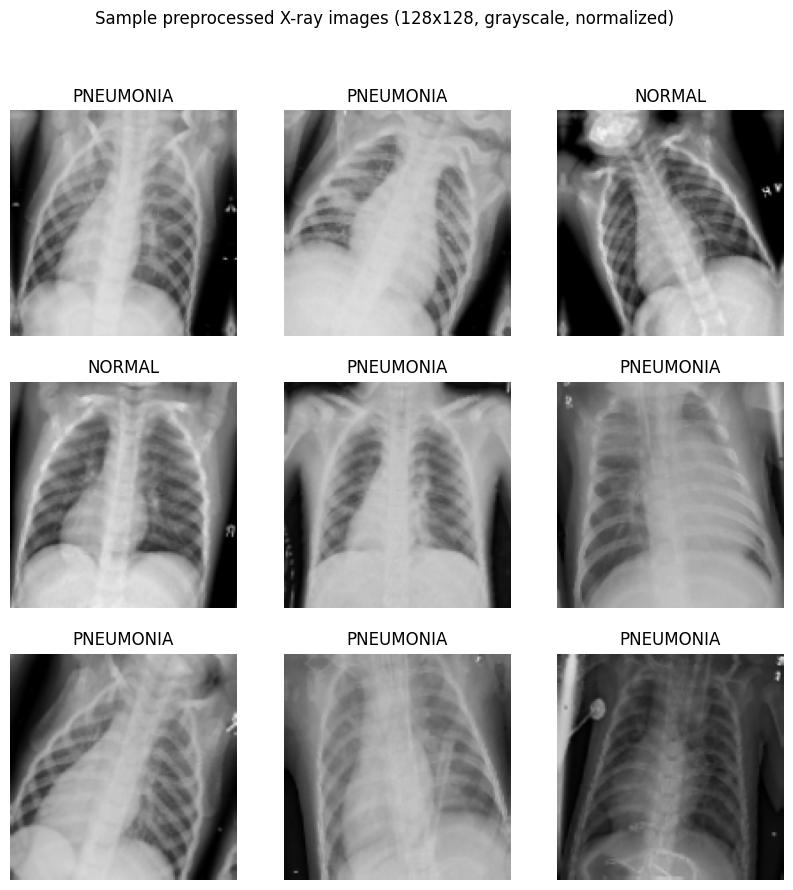

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        img = images[i]
        plt.imshow(np.squeeze(img), cmap='gray')  # 👈 force grayscale display
        title = class_names[int(labels[i])]
        plt.title(title)
        plt.axis('off')

plt.suptitle("Sample preprocessed X-ray images (128x128, grayscale, normalized)")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification (Normal vs Pneumonia)
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/drive/MyDrive/X ray Dataset/chest_xray/train"
val_dir   = "/content/drive/MyDrive/X ray Dataset/chest_xray/val"
test_dir  = "/content/drive/MyDrive/X ray Dataset/chest_xray/test"



In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128,128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5263 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 79s 443ms/step - accuracy: 0.7591 - loss: 0.5236 - val_accuracy: 0.6250 - val_loss: 1.0292
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 62s 375ms/step - accuracy: 0.8970 - loss: 0.2522 - val_accuracy: 0.7500 - val_loss: 0.7264
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 348ms/step - accuracy: 0.9137 - loss: 0.2138 - val_accuracy: 0.8750 - val_loss: 0.4312
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 59s 357ms/step - accuracy: 0.9286 - loss: 0.1788 - val_accuracy: 0.5625 - val_loss: 1.0321
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 58s 352ms/step - accuracy: 0.9295 - loss: 0.1798 - val_accuracy: 0.8750 - val_loss: 0.4517
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 348ms/step - accuracy: 0.9332 - loss: 0.1745 - val_accuracy: 0.8125 - val_loss: 0.4252
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 58s 349ms/step - accuracy: 0.9471 - loss: 0.1537 - val_accuracy: 0.5625 - val_loss: 0.8677
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 57s 346ms/step - accuracy: 0.9530 - loss: 0

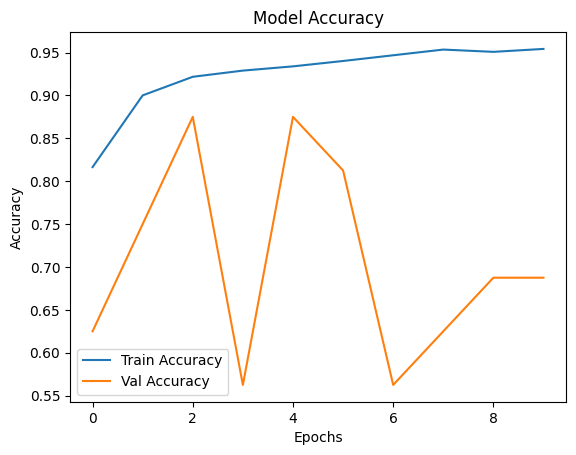

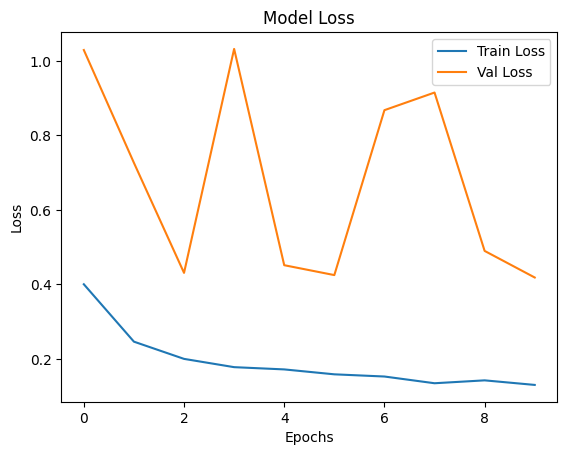

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 263s 14s/step - accuracy: 0.7555 - loss: 0.7902
✅ Test Accuracy: 86.06%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


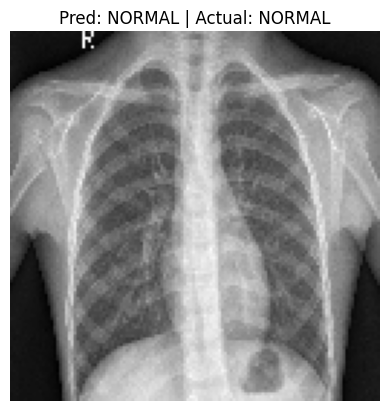

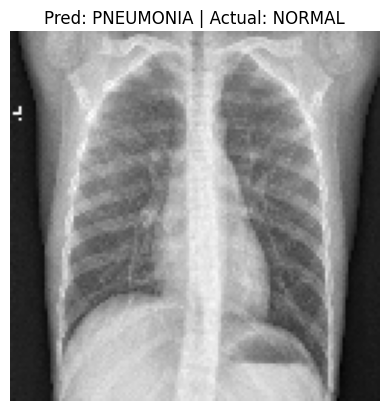

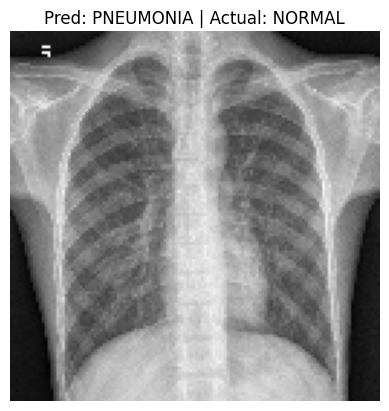

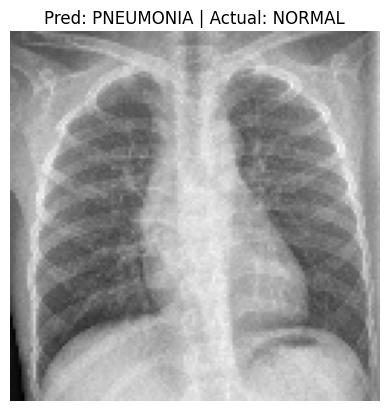

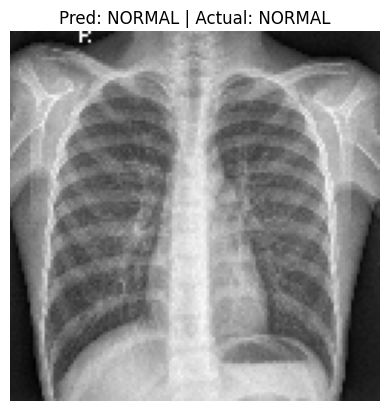

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Get a batch of test images
batch = next(test_data)
imgs, labels = batch

# Predict
preds = model.predict(imgs)
pred_classes = (preds > 0.5).astype("int32")

# Display some results
for i in range(5):
    plt.imshow(imgs[i].reshape(128,128), cmap='gray')
    plt.title(f"Pred: {'PNEUMONIA' if pred_classes[i][0] == 1 else 'NORMAL'} | Actual: {'PNEUMONIA' if labels[i]==1 else 'NORMAL'}")
    plt.axis('off')
    plt.show()

In [ ]:
model.save('/content/drive/MyDrive/X ray Dataset/pneumonia_cnn_model.h5')
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model (you can skip if it's already in memory)
model = load_model('/content/drive/MyDrive/X ray Dataset/pneumonia_cnn_model.h5')

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_data)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.7555 - loss: 0.7902
✅ Test Accuracy: 86.06%
✅ Test Loss: 0.4847


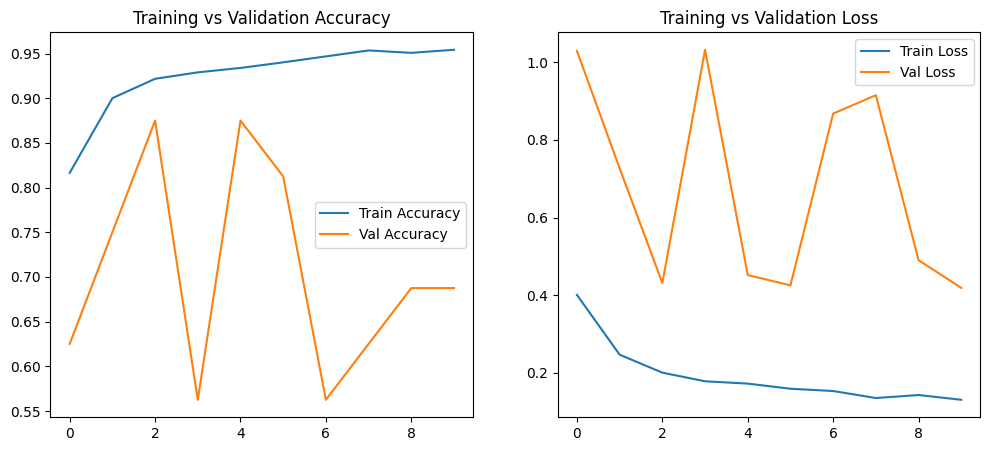

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step


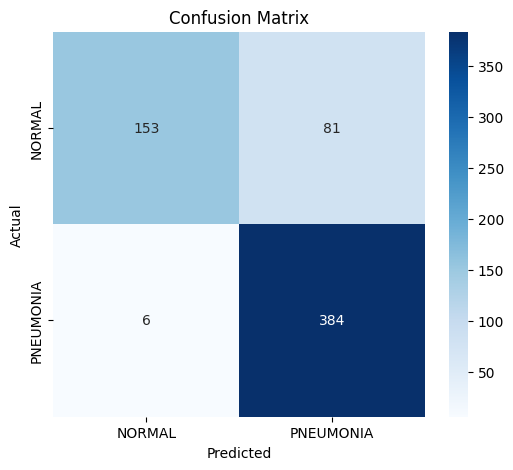

              precision    recall  f1-score   support

      NORMAL       0.96      0.65      0.78       234
   PNEUMONIA       0.83      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Predict labels for test data
predictions = model.predict(test_data)
predicted_classes = np.where(predictions > 0.5, 1, 0)

# True labels
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


In [ ]:
import cv2
import numpy as np

img_path = "/content/drive/MyDrive/X ray Dataset/chest_xray/test/NORMAL/IM-0001-0001.jpeg"  # Change this to any image path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128))
img = img / 255.0
img = np.expand_dims(img, axis=(0, -1))  # (1,128,128,1)

prediction = model.predict(img)[0][0]

if prediction > 0.5:
    print("🫁 Predicted: PNEUMONIA")
else:
    print("🫀 Predicted: NORMAL")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🫀 Predicted: NORMAL


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/X ray Dataset/results/accuracy_loss_plot.png'

<Figure size 640x480 with 0 Axes>